In [1]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib
!pip install numpy


In [2]:
import numpy as np
import cv2
import random

IMG_SIZE = 128

SHAPE_TYPES = ["circle", "square", "triangle"]

# --- helper for rotation ---
def rotate_polygon(points, center, angle_deg):
    angle = np.deg2rad(angle_deg)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    pts = points - center
    pts_rot = pts @ R.T + center
    return pts_rot.astype(np.int32)

def draw_random_shape(img_size=IMG_SIZE):
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    mask = np.zeros((img_size, img_size), dtype=np.uint8)

    shape = random.choice(SHAPE_TYPES)

    # background ~0–55
    bg_level = random.randint(0, 55)
    img[:] = bg_level

    # object ~200–255
    obj_level = random.randint(200, 255)

    # random rotation for square/triangle (circle is rotation-invariant)
    angle = random.uniform(0, 180) if shape in ("square", "triangle") else 0.0

    if shape == "circle":
        r = random.randint(10, 25)  # radius
        cx = random.randint(r + 2, img_size - r - 2)
        cy = random.randint(r + 2, img_size - r - 2)
        cv2.circle(img, (cx, cy), r, int(obj_level), -1)
        cv2.circle(mask, (cx, cy), r, 1, -1)

    elif shape == "square":
        half = random.randint(12, 25)
        # ensure rotated square stays inside image
        max_r = int(np.ceil(half * np.sqrt(2)))
        cx = random.randint(max_r + 2, img_size - max_r - 2)
        cy = random.randint(max_r + 2, img_size - max_r - 2)

        base_pts = np.array([
            [cx - half, cy - half],
            [cx + half, cy - half],
            [cx + half, cy + half],
            [cx - half, cy + half],
        ], dtype=np.float32)

        pts = rotate_polygon(base_pts,
                             np.array([cx, cy], dtype=np.float32),
                             angle)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(img, [pts], int(obj_level))
        cv2.fillPoly(mask, [pts], 1)

    else:  # triangle
        span = random.randint(30, 60)
        # max distance of a vertex from center is span / sqrt(2)
        max_r = int(np.ceil(span / np.sqrt(2)))

        cx = random.randint(max_r + 2, img_size - max_r - 2)
        cy = random.randint(max_r + 2, img_size - max_r - 2)

        base_pts = np.array([
            [cx,             cy - span // 2],
            [cx - span // 2, cy + span // 2],
            [cx + span // 2, cy + span // 2],
        ], dtype=np.float32)

        pts = rotate_polygon(base_pts,
                             np.array([cx, cy], dtype=np.float32),
                             angle)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(img, [pts], int(obj_level))
        cv2.fillPoly(mask, [pts], 1)

    return img, mask, shape

def generate_dataset(n_samples, img_size=IMG_SIZE, seed=0):
    random.seed(seed)
    np.random.seed(seed)

    images = []
    masks = []
    labels = []  # for picking 2 of each shape later

    for _ in range(n_samples):
        img, mask, shape = draw_random_shape(img_size)
        images.append(img)
        masks.append(mask)
        labels.append(shape)

    images = np.stack(images, axis=0)  # (N, H, W)
    masks = np.stack(masks, axis=0)    # (N, H, W)
    return images, masks, np.array(labels)

# Generate data
train_images, train_masks, train_labels = generate_dataset(1000, seed=0)
test_images,  test_masks,  test_labels  = generate_dataset(200,  seed=42)


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class ShapesDataset(Dataset):
    def __init__(self, images, masks):
        # images: (N, H, W), 0–255
        self.images = images.astype(np.float32) / 255.0
        self.masks  = masks.astype(np.float32)        # 0/1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx][None, ...]    # (1, H, W)
        mask = self.masks[idx][None, ...]    # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

train_ds = ShapesDataset(train_images, train_masks)
test_ds  = ShapesDataset(test_images,  test_masks)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

# ---------- U-Net blocks ----------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(1, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(32, 64)

        # Decoder
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(32 + 32, 32)
        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(16 + 16, 16)

        # Output
        self.out_conv = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)          # (16, 128, 128)
        p1 = self.pool1(x1)         # (16, 64, 64)
        x2 = self.down2(p1)         # (32, 64, 64)
        p2 = self.pool2(x2)         # (32, 32, 32)

        # Bottleneck
        b = self.bottleneck(p2)     # (64, 32, 32)

        # Decoder
        u2 = self.up2(b)            # (32, 64, 64)
        u2 = torch.cat([u2, x2], dim=1)
        d2 = self.dec2(u2)          # (32, 64, 64)

        u1 = self.up1(d2)           # (16, 128, 128)
        u1 = torch.cat([u1, x1], dim=1)
        d1 = self.dec1(u1)          # (16, 128, 128)

        logits = self.out_conv(d1)  # (1, 128, 128)
        return logits


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetSmall().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 15
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, masks in train_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}")


Epoch 1/15 - Train Loss: 0.1874
Epoch 2/15 - Train Loss: 0.0033
Epoch 3/15 - Train Loss: 0.0022
Epoch 4/15 - Train Loss: 0.0015
Epoch 5/15 - Train Loss: 0.0010
Epoch 6/15 - Train Loss: 0.0007
Epoch 7/15 - Train Loss: 0.0005
Epoch 8/15 - Train Loss: 0.0003
Epoch 9/15 - Train Loss: 0.0002
Epoch 10/15 - Train Loss: 0.0002
Epoch 11/15 - Train Loss: 0.0001
Epoch 12/15 - Train Loss: 0.0001
Epoch 13/15 - Train Loss: 0.0001
Epoch 14/15 - Train Loss: 0.0001
Epoch 15/15 - Train Loss: 0.0000


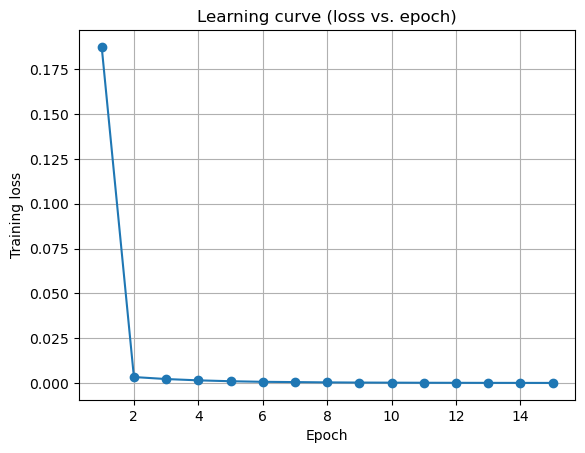

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Learning curve (loss vs. epoch)")
plt.grid(True)
plt.show()


In [6]:
def evaluate_metrics(model, loader, device):
    model.eval()
    tp = tn = fp = fn = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            probs  = torch.sigmoid(logits)
            preds  = (probs > 0.5).float()

            tp += torch.sum((preds == 1) & (masks == 1)).item()
            tn += torch.sum((preds == 0) & (masks == 0)).item()
            fp += torch.sum((preds == 1) & (masks == 0)).item()
            fn += torch.sum((preds == 0) & (masks == 1)).item()

    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total
    iou = tp / (tp + fp + fn + 1e-8)

    return tp, tn, fp, fn, accuracy, iou

tp, tn, fp, fn, acc, iou = evaluate_metrics(model, test_loader, device)
print(f"TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print(f"Accuracy: {acc:.4f}")
print(f"IoU: {iou:.4f}")


TP=243946, TN=3032836, FP=1, FN=17
Accuracy: 1.0000
IoU: 0.9999


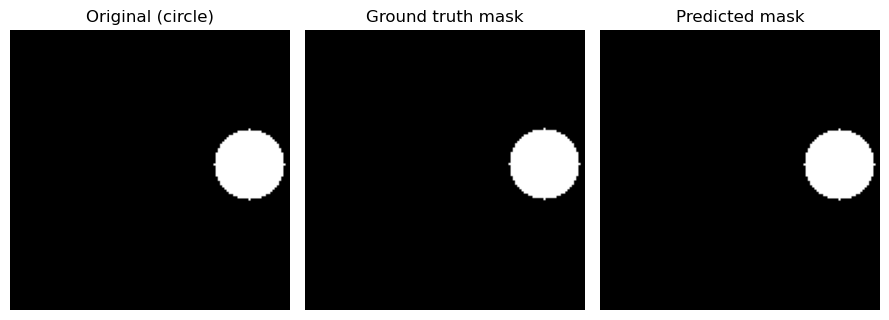

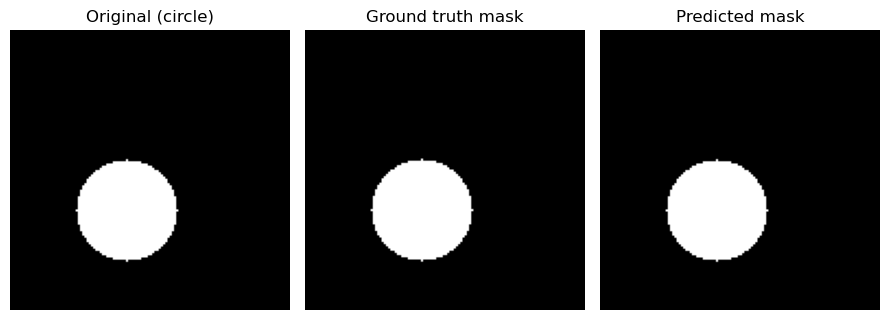

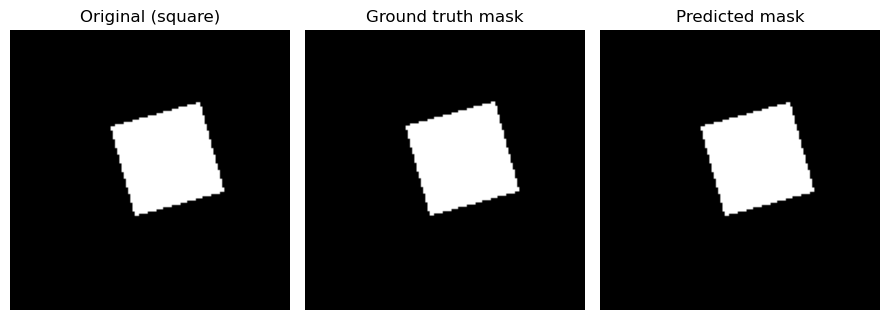

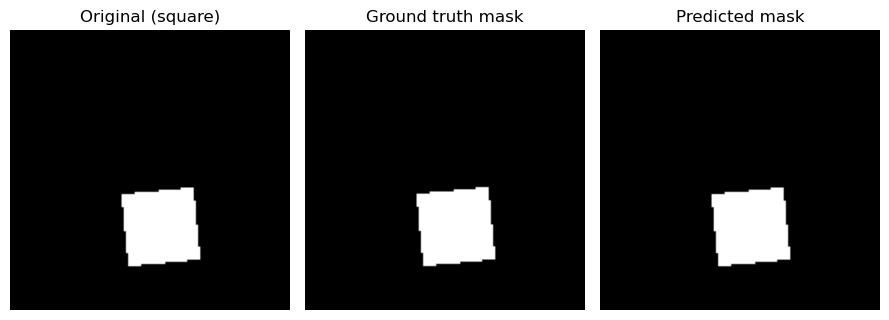

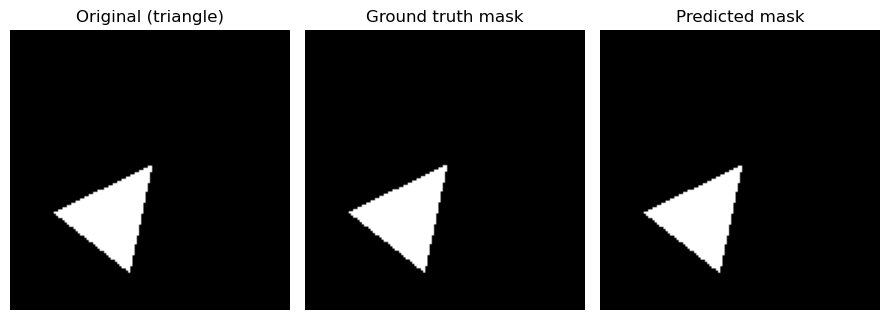

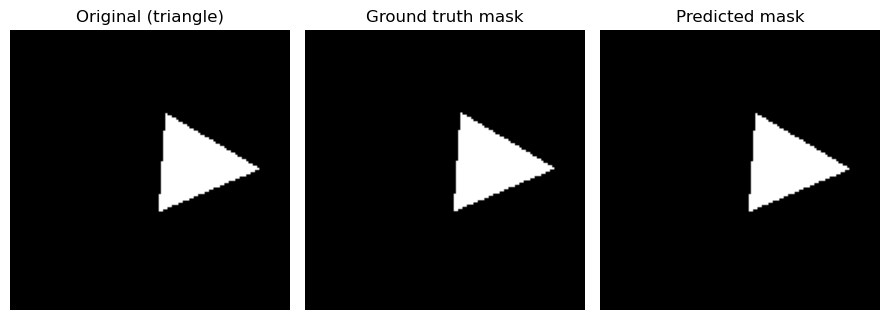

In [9]:
import numpy.random as npr

def show_examples(model, images, masks, labels, device, n_per_shape=2):
    model.eval()
    plt.rcParams["figure.figsize"] = (9, 6)

    shape_to_indices = {s: np.where(labels == s)[0] for s in SHAPE_TYPES}

    chosen_indices = []
    for s in SHAPE_TYPES:
        idxs = shape_to_indices[s]
        chosen = npr.choice(idxs, size=n_per_shape, replace=False)
        chosen_indices.extend(chosen.tolist())

    with torch.no_grad():
        for i, idx in enumerate(chosen_indices):
            img = images[idx].astype(np.float32)/255.0
            mask = masks[idx]
            inp = torch.from_numpy(img[None, None, ...]).to(device)
            logits = model(inp)
            prob = torch.sigmoid(logits)[0,0].cpu().numpy()
            pred_mask = (prob > 0.5).astype(np.uint8)

            plt.figure()
            plt.subplot(1,3,1)
            plt.imshow(img, cmap="gray")
            plt.title(f"Original ({labels[idx]})")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.imshow(mask, cmap="gray")
            plt.title("Ground truth mask")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.imshow(pred_mask, cmap="gray")
            plt.title("Predicted mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

show_examples(model, test_images, test_masks, test_labels, device)
